In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T 

from PIL import Image
import requests
import matplotlib.pyplot as plt 

from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR
import io

g:\Fine-GrainedSceneGraph-Generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'SourceBaseline'

In [3]:
CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

In [4]:
position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8, 
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)

# The checkpoint is pretrained on Visual Genome
ckpt = torch.hub.load_state_dict_from_url(
    url='https://cloud.tnt.uni-hannover.de/index.php/s/PB8xTKspKZF7fyK/download/checkpoint0149.pth',
    map_location='cpu', check_hash=True)
model.load_state_dict(ckpt['model'])
model.eval()

g:\Fine-grained_SceneGraph\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\Fine-grained_SceneGraph\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RelTR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn_entity): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features

In [8]:
# Some transformation functions
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

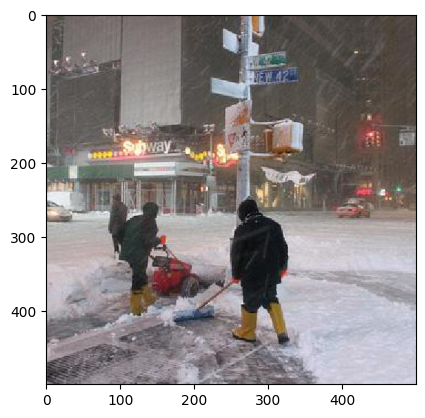

In [9]:
#url = '0D49EE4F095FE124581697B063CF71C31D4C04F01111.jpg'
url = 'data/Incidents/incidents_cleaned/test/snow/0D49EE4F095FE124581697B063CF71C31D4C04F0.jpg'
#r = requests.get(url, stream=True)
im = Image.open(url)
plt.imshow(im)
img = transform(im).unsqueeze(0)

In [10]:
# propagate through the model
outputs = model(img)

# keep only predictions with >0.3 confidence
probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]
probas_sub = outputs['sub_logits'].softmax(-1)[0, :, :-1]
probas_obj = outputs['obj_logits'].softmax(-1)[0, :, :-1]
keep = torch.logical_and(probas.max(-1).values > 0.3, torch.logical_and(probas_sub.max(-1).values > 0.3,
                                                                        probas_obj.max(-1).values > 0.3))

In [11]:
outputs['rel_logits']

tensor([[[-23.3684,  -3.6896,  -8.3221,  ..., -16.9006,  -3.8974,   0.1007],
         [-27.5991,  -5.2020,  -7.2361,  ..., -20.0884,  -9.4648,  -0.1976],
         [-26.5973,  -8.1565, -11.4933,  ..., -11.5089,  -9.7676,  -0.9477],
         ...,
         [-26.7398,  -8.5497,  -9.3872,  ..., -17.2493,  -9.3269,  -0.7368],
         [-23.5686,  -8.6238, -12.3472,  ..., -16.9865,  -2.1807,  -0.2634],
         [-31.6874,  -6.8177,  -9.2032,  ..., -17.4664,  -7.3396,   1.0846]]],
       grad_fn=<SelectBackward0>)

In [12]:
probas

tensor([[5.6442e-11, 1.9861e-02, 1.9325e-04,  ..., 2.3193e-06, 3.6353e-08,
         1.6135e-02],
        [9.2138e-13, 4.9130e-03, 6.4261e-04,  ..., 1.6214e-07, 1.6838e-09,
         6.9191e-05],
        [5.1460e-12, 5.2502e-04, 1.8667e-05,  ..., 1.6952e-05, 1.8377e-05,
         1.0484e-04],
        ...,
        [4.7262e-12, 3.7528e-04, 1.6242e-04,  ..., 9.1872e-08, 6.2543e-08,
         1.7251e-04],
        [5.5625e-11, 1.7206e-04, 4.1555e-06,  ..., 3.9455e-06, 4.0163e-08,
         1.0811e-01],
        [5.7937e-15, 3.6621e-04, 3.3704e-05,  ..., 1.3484e-06, 8.6905e-09,
         2.1730e-04]], grad_fn=<SliceBackward0>)

In [13]:
# convert boxes from [0; 1] to image scales
sub_bboxes_scaled = rescale_bboxes(outputs['sub_boxes'][0, keep], im.size)
obj_bboxes_scaled = rescale_bboxes(outputs['obj_boxes'][0, keep], im.size)

topk = 10 # display up to 10 images
keep_queries = torch.nonzero(keep, as_tuple=True)[0]
indices = torch.argsort(-probas[keep_queries].max(-1)[0] * probas_sub[keep_queries].max(-1)[0] * probas_obj[keep_queries].max(-1)[0])[:topk]
keep_queries = keep_queries[indices]

In [14]:
# save the attention weights
conv_features, dec_attn_weights_sub, dec_attn_weights_obj = [], [], []
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.decoder.layers[-1].cross_attn_sub.register_forward_hook(
        lambda self, input, output: dec_attn_weights_sub.append(output[1])
    ),
    model.transformer.decoder.layers[-1].cross_attn_obj.register_forward_hook(
        lambda self, input, output: dec_attn_weights_obj.append(output[1])
    )]

In [15]:
len(obj_bboxes_scaled)

14

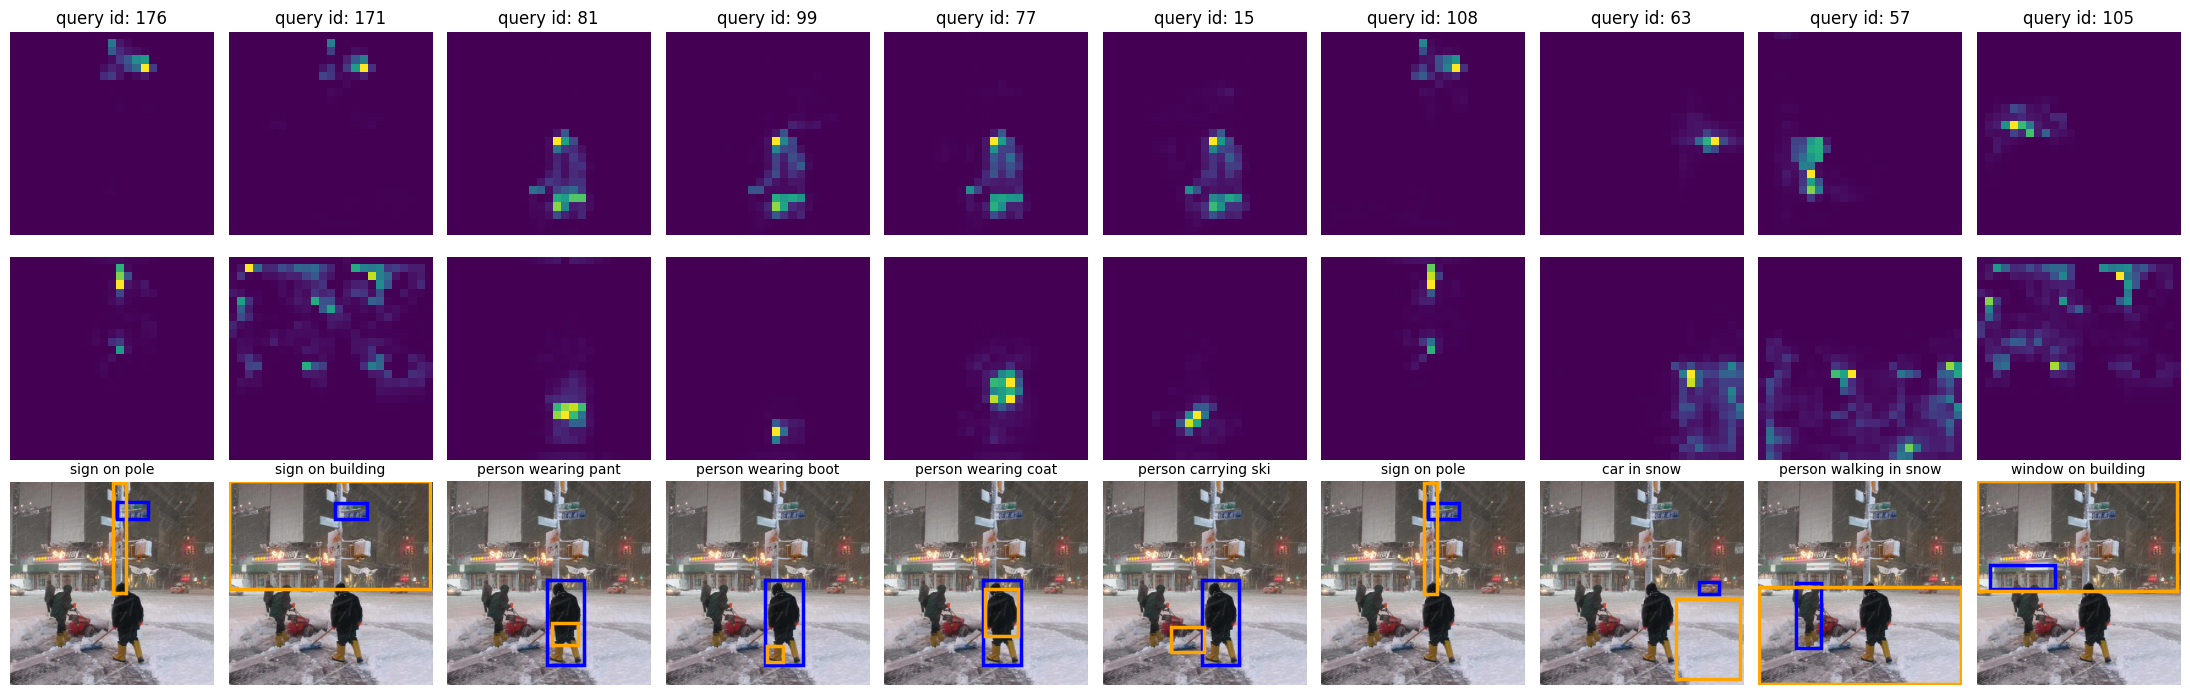

In [16]:
with torch.no_grad():
    # propagate through the model
    outputs = model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    dec_attn_weights_sub = dec_attn_weights_sub[0]
    dec_attn_weights_obj = dec_attn_weights_obj[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    im_w, im_h = im.size

    fig, axs = plt.subplots(ncols=len(indices), nrows=3, figsize=(22, 7))
    for idx, ax_i, (sxmin, symin, sxmax, symax), (oxmin, oymin, oxmax, oymax) in \
            zip(keep_queries, axs.T, sub_bboxes_scaled[indices], obj_bboxes_scaled[indices]):
        ax = ax_i[0]
        ax.imshow(dec_attn_weights_sub[0, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(dec_attn_weights_obj[0, idx].view(h, w))
        ax.axis('off')
        ax = ax_i[2]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((sxmin, symin), sxmax - sxmin, symax - symin,
                                    fill=False, color='blue', linewidth=2.5))
        ax.add_patch(plt.Rectangle((oxmin, oymin), oxmax - oxmin, oymax - oymin,
                                    fill=False, color='orange', linewidth=2.5))

        ax.axis('off')
        ax.set_title(CLASSES[probas_sub[idx].argmax()]+' '+REL_CLASSES[probas[idx].argmax()]+' '+CLASSES[probas_obj[idx].argmax()], fontsize=10)

    fig.tight_layout()
    plt.show() # show the output


In [12]:
probas_sub

tensor([[8.2949e-10, 1.7295e-07, 1.4892e-06,  ..., 3.2560e-04, 4.3027e-05,
         4.1248e-11],
        [2.3054e-09, 6.4516e-07, 2.2300e-06,  ..., 4.6819e-04, 2.9119e-05,
         5.4656e-11],
        [1.2673e-08, 3.9545e-07, 2.1625e-05,  ..., 2.2948e-05, 1.5100e-02,
         2.4641e-08],
        ...,
        [7.4519e-09, 2.3445e-06, 1.0544e-05,  ..., 1.1410e-05, 1.7506e-05,
         6.7779e-09],
        [2.2554e-10, 8.0881e-07, 8.2740e-07,  ..., 1.2808e-04, 7.6645e-06,
         6.1967e-10],
        [3.9755e-11, 3.4976e-07, 1.9911e-07,  ..., 2.4550e-04, 2.8613e-07,
         5.1349e-10]], grad_fn=<SliceBackward0>)

In [13]:
probas

tensor([[5.6442e-11, 1.9861e-02, 1.9325e-04,  ..., 2.3193e-06, 3.6353e-08,
         1.6135e-02],
        [9.2138e-13, 4.9130e-03, 6.4261e-04,  ..., 1.6214e-07, 1.6838e-09,
         6.9191e-05],
        [5.1460e-12, 5.2502e-04, 1.8667e-05,  ..., 1.6952e-05, 1.8377e-05,
         1.0484e-04],
        ...,
        [4.7262e-12, 3.7528e-04, 1.6242e-04,  ..., 9.1872e-08, 6.2543e-08,
         1.7251e-04],
        [5.5625e-11, 1.7206e-04, 4.1555e-06,  ..., 3.9455e-06, 4.0163e-08,
         1.0811e-01],
        [5.7937e-15, 3.6621e-04, 3.3704e-05,  ..., 1.3484e-06, 8.6905e-09,
         2.1730e-04]], grad_fn=<SliceBackward0>)

In [14]:
probas_obj

tensor([[6.4592e-10, 6.0627e-08, 1.3413e-06,  ..., 1.2012e-03, 4.1102e-06,
         1.2888e-11],
        [8.1037e-11, 2.2225e-07, 4.5383e-07,  ..., 8.8357e-05, 5.4273e-06,
         2.4427e-10],
        [5.9064e-11, 6.1089e-10, 1.6752e-06,  ..., 1.3666e-05, 5.4770e-06,
         3.0429e-11],
        ...,
        [2.3560e-11, 3.6877e-09, 8.8717e-07,  ..., 2.7741e-06, 6.3033e-06,
         1.4954e-10],
        [1.0079e-09, 1.5743e-07, 2.4296e-06,  ..., 1.3955e-03, 2.6632e-06,
         1.1938e-11],
        [8.5861e-09, 5.9700e-07, 6.1762e-05,  ..., 9.6443e-06, 7.5835e-03,
         2.1529e-07]], grad_fn=<SliceBackward0>)

In [16]:
for idx, ax_i, (sxmin, symin, sxmax, symax), (oxmin, oymin, oxmax, oymax) in \
            zip(keep_queries, axs.T, sub_bboxes_scaled[indices], obj_bboxes_scaled[indices]):
    print(CLASSES[probas_sub[idx].argmax()]+' '+REL_CLASSES[probas[idx].argmax()]+' '+CLASSES[probas_obj[idx].argmax()])

sign on pole
sign on building
person wearing pant
person wearing boot
person wearing coat
person carrying ski
sign on pole
car in snow
person walking in snow
window on building
